In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import imageio
import os

%matplotlib inline

## Camera Calibration

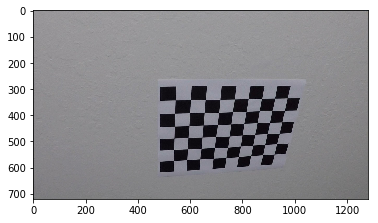

In [2]:

image_names = os.listdir("camera_cal/")

#reading in an image
image = mpimg.imread('camera_cal/'+image_names[1])

plt.imshow(image)  



In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for idx, fname in enumerate(image_names):
    img = cv2.imread('camera_cal/'+fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'cal_corners/corners_found'+str(idx)+'.jpg'
        imageio.imwrite(write_name, img)

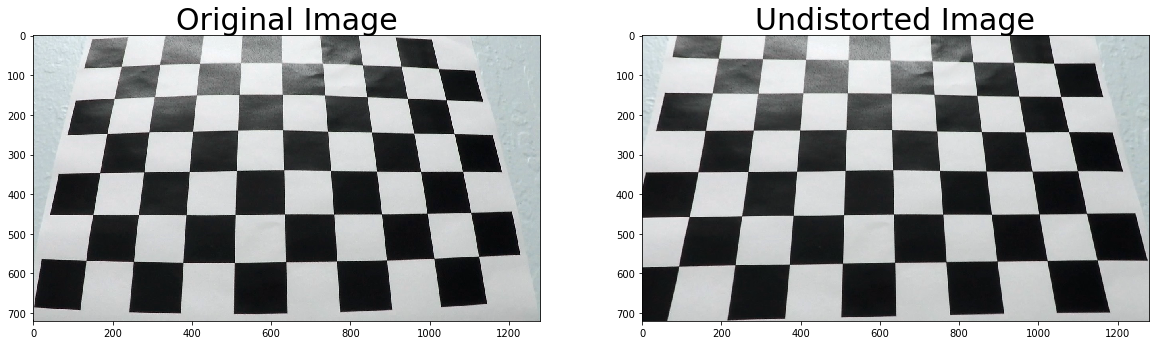

In [4]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
imageio.imwrite('output_images/original.jpg', img)
imageio.imwrite('output_images/undistorted_cal_img.jpg', dst)

## Using Calibration to Undistort Roadway Images

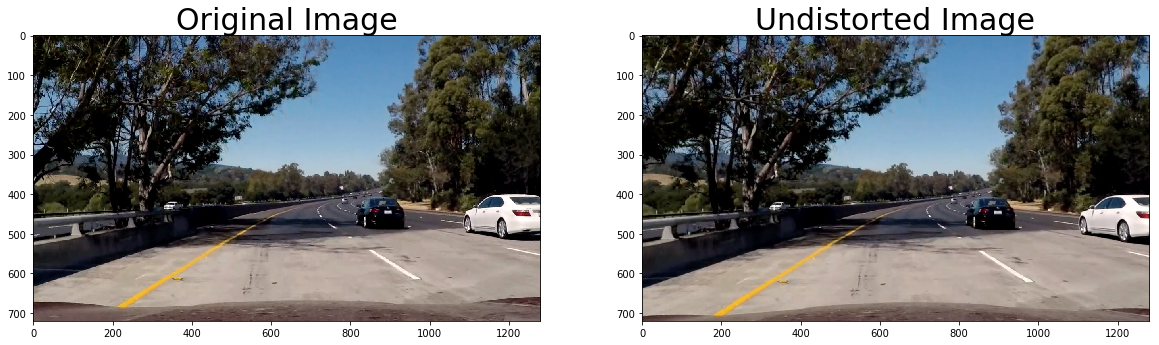

In [5]:
raw_img = cv2.imread('./test_images/test5.jpg')
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
dst = cv2.undistort(raw_img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
imageio.imwrite('output_images/original_test_img.jpg', raw_img)
imageio.imwrite('output_images/undistorted_test_img.jpg', dst)

## Establishing Source Points for Bird's Eye View Distortion

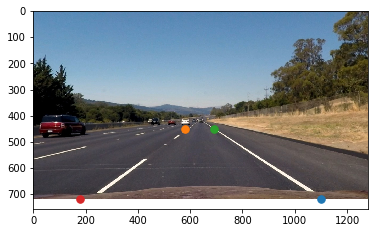

In [6]:
straight_img = cv2.imread('./test_images/straight_lines2.jpg')
img = cv2.cvtColor(straight_img, cv2.COLOR_BGR2RGB)
dist_img = cv2.undistort(img, mtx, dist, None, mtx)

plt.imshow(dist_img)

plt.plot(1100,img.shape[0],'.',markersize = 15)
plt.plot(580,450,'.',markersize = 15)
plt.plot(690,450,'.',markersize = 15)
plt.plot(180,img.shape[0],'.',markersize = 15)

imageio.imwrite('output_images/source_points.jpg', dist_img)

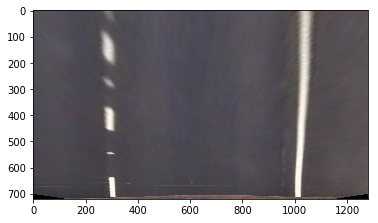

In [7]:

src_pts = np.float32(
    [[1100,720],
    [594,450],
    [684,450],
    [180,720]])
dst_pts = np.float32(
    [[1005,720],
    [275,0],
    [1005,0],
    [275,720]])
#Calculating the Linear Transformation Matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(dist_img,M,(1280,720),flags=cv2.INTER_LINEAR)
plt.imshow(warped)
imageio.imwrite('output_images/warped.jpg', warped)
#Calculating the Inverse Linear Transformation Matrix
Minv = cv2.getPerspectiveTransform(dst_pts,src_pts)
inv_warped = cv2.warpPerspective(warped,Minv,(1280,720))
#plt.imshow(inv_warped)
imageio.imwrite('output_images/inv_warped.jpg', inv_warped)

## Saving the Calibration information

In [8]:
import pickle
new_file = open('data.pk1','wb')
pickle.dump(mtx, new_file)
pickle.dump(dist, new_file, -1)
pickle.dump(src_pts, new_file, -1)
pickle.dump(src_pts, new_file, -1)
pickle.dump(M, new_file, -1)
pickle.dump(Minv, new_file, -1)
new_file.close()

## Creating a Binary Image Using Color and Gradient Filtering

In [9]:
def binary_image(dist_img):
    
    #color transforms
    hls = cv2.cvtColor(dist_img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    thresh = (170, 255)
    S_binary = np.zeros_like(S)
    S_binary[(S > thresh[0]) & (S <= thresh[1])] = 1

    #Gradient transforms
    R1 = dist_img[:,:,2]
    R2 = hls[:,:,1]
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 80

    # Sobel x
    #R channel
    sobelx1 = cv2.Sobel(R1, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx1 = np.absolute(sobelx1) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel1 = np.uint8(255*abs_sobelx1/np.max(abs_sobelx1))
    #L channel
    sobelx2 = cv2.Sobel(R2, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx2 = np.absolute(sobelx2) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel2 = np.uint8(255*abs_sobelx2/np.max(abs_sobelx2))

    sxbinary1 = np.zeros_like(scaled_sobel1)
    sxbinary1[(scaled_sobel1 >= thresh_min) & (scaled_sobel1 <= thresh_max)] = 1
    sxbinary2 = np.zeros_like(scaled_sobel2)
    sxbinary2[(scaled_sobel2 >= thresh_min) & (scaled_sobel2 <= thresh_max)] = 1

    # Combine the three binary thresholds
    combined_binary = np.zeros_like(sxbinary1)
    combined_binary[(sxbinary1 == 1) | (sxbinary2 == 1)| (S_binary==1)] = 1
    return combined_binary

## Determining Best Fit Polynomial in units of  Pixels and Meters 

In [10]:
def finding_lines(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 90
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #Fit a second order polynomial in meters
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_real = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_real = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit, right_fit, left_real, right_real

## Image Pipeline
* Takes in raw images
* Outputs information about the lane curvature and position of the vehicle

In [11]:

def image_pipeline(img):
    #Apply a distortion correction to raw image.
    dist_img = cv2.undistort(img, mtx, dist, None, mtx)
    #BINARY IMAGE
    combined_binary = binary_image(dist_img)
    #Apply a perspective transform to rectify binary image ("birds-eye view").
    src_pts = np.float32(
        [[1100,720],
        [594,450],
        [684,450],
        [180,720]])
    dst_pts = np.float32(
        [[1005,720],
        [275,0],
        [1005,0],
        [275,720]])
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    binary_warped = cv2.warpPerspective(combined_binary,M,(1280,720),flags=cv2.INTER_LINEAR)
    #Detect lane pixels and fit to find the lane boundary.
    left_fit, right_fit, left_real, right_real = finding_lines(binary_warped)
    #Determine the curvature of the lane and vehicle position with respect to center.
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700
    y_eval = 720
    # Calculate the radii of curvature
    left_curverad = ((1 + (2*left_real[0]*y_eval*ym_per_pix + left_real[1])**2)**1.5) / np.absolute(2*left_real[0])
    right_curverad = ((1 + (2*right_real[0]*y_eval*ym_per_pix + right_real[1])**2)**1.5) / np.absolute(2*right_real[0])
    #Calculate the distance from center of the lane 
    L_pixel = (left_fit[0]*y_eval**2)+(left_fit[1]*y_eval)+left_fit[2]
    R_pixel = (right_fit[0]*y_eval**2)+(right_fit[1]*y_eval)+right_fit[2]
    D_from_center = -(((R_pixel-L_pixel))-640)*xm_per_pix
    
    return left_fit, right_fit, binary_warped, left_curverad, right_curverad, D_from_center, L_pixel, R_pixel

In [12]:
#Evaluating a test image
raw_img = cv2.imread('./test_images/test1.jpg')
undist = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
left_fit, right_fit, binary_warped, left_curverad, right_curverad, D_from_center, L_pixel, R_pixel= image_pipeline(undist)



In [13]:
print(left_curverad, right_curverad, D_from_center, L_pixel, R_pixel)

335.857129545 378.137580784 -0.480995683803 329.331288748 1060.33047217


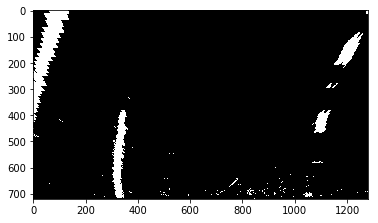

In [14]:
plt.imshow(binary_warped,cmap="gray")
imageio.imwrite('output_images/binary_warped.jpg', binary_warped)

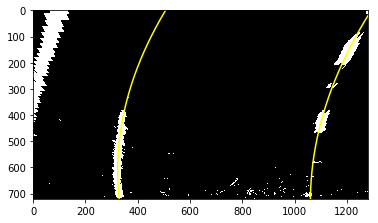

In [15]:

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 90
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

imageio.imwrite('output_images/lane_curves.jpg', out_img)

(720, 0)

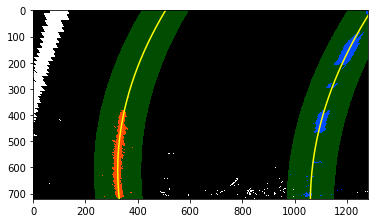

In [18]:

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

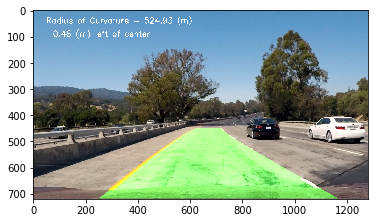

In [16]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
if D_from_center < 0:
    side = 'left'
else:
    side = 'right'
    
cv2.putText(result,'Radius of Curvature = '+str(round((left_curverad+right_curverad/2),2))+' (m)',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
cv2.putText(result,str(round((D_from_center),2))+' (m) '+side+ ' of center',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
plt.imshow(result)
imageio.imwrite('output_images/result.jpg', result)